<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Test-1---Running-Various-Untuned-Classifiers-and-picking-some-for-extensive-testing" data-toc-modified-id="Test-1---Running-Various-Untuned-Classifiers-and-picking-some-for-extensive-testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test 1 - Running Various Untuned Classifiers and picking some for extensive testing</a></span></li><li><span><a href="#Test-2---Hyperparameter-tuning-for-Random-Forest" data-toc-modified-id="Test-2---Hyperparameter-tuning-for-Random-Forest-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test 2 - Hyperparameter tuning for Random Forest</a></span><ul class="toc-item"><li><span><a href="#First-experimenting-with-decision-tree" data-toc-modified-id="First-experimenting-with-decision-tree-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>First experimenting with decision tree</a></span></li></ul></li></ul></div>

In [48]:
# Packages

import sys
print("Python version: {}". format(sys.version))

import os
print("OS version: {}". format(os.uname()))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
print("matplotlib version: {}". format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

#misc
import random
import time

print('-'*25)

Python version: 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
OS version: posix.uname_result(sysname='Darwin', nodename='Bings-MacBook-Pro.local', release='17.4.0', version='Darwin Kernel Version 17.4.0: Sun Dec 17 09:19:54 PST 2017; root:xnu-4570.41.2~1/RELEASE_X86_64', machine='x86_64')
pandas version: 0.23.1
matplotlib version: 2.2.2
NumPy version: 1.14.5
SciPy version: 1.1.0
scikit-learn version: 0.19.1
-------------------------


In [49]:
PATH = "AML-DATA/"

# 250 top scoring genes
X_250 = pd.read_csv(PATH + "X_subset_250.csv", index_col = 0)

# 24 gene-signature derived from bigX
X_signature = pd.read_csv(PATH + "X_signature_24.csv", index_col = 0)

# Right now pkl version of file doesn't have DataFrame/Series type problem (as opposed to csv version)
y = pd.read_pickle(PATH + "PROCESSED-TARGET-AML-Y.pkl")

## Test 1 - Running Various Untuned Classifiers and picking some for extensive testing

Not testing Random Forest, Voting, and Gradient Boosting here, but they will be used in final testing (computational reasons)


RESULTS:

* All SVM variations and Logistic Regression are promising with more tuning

* L2-SVM in particular achieves above .98 score in all 3 metrics, better than previous studies

* Additionally - replacing X_signature with X_250 in the "Actual Testing" cell provides evidence that the L1-SVM feature selection was effective.

In [50]:
# Various Classifiers
from sklearn.svm import SVC # RBF kernel SVM
from sklearn.svm import LinearSVC # L1 and L2 reg. SVMs
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbors (needs some extra tuning here for k)
from sklearn.linear_model import LogisticRegression # L2 reg. Logistic Regression
from sklearn.naive_bayes import GaussianNB # Naive Bayes

# Model validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from tqdm import tqdm_notebook

In [51]:
# SET UP

k_fold = RepeatedStratifiedKFold(10, n_repeats = 10, random_state = 100)

# Keys = classifiers, stored-values = [accuracy, roc_aucs, f1]
clfDict = {SVC(kernel = "rbf") : [[],[],[]],
           
           LinearSVC(penalty = "l1", dual = False) : [[],[],[]], LinearSVC(penalty = "l2") : [[],[],[]], 
           
           KNeighborsClassifier(n_neighbors = 8, p = 3): [[],[],[]],
           
           LogisticRegression(C = 0.01) : [[],[],[]],
           
           GaussianNB() : [[],[],[]]
          }

In [52]:
# ACTUAL TESTING


for clf in tqdm_notebook(clfDict.keys()):
    
    k = 1
    for k, (train, test) in enumerate(k_fold.split(X_signature, y)):

        clf.fit(X_signature.iloc[train], y.iloc[train])
       
    
        y_pred = clf.predict(X_signature.iloc[test])
        
        accuracy = accuracy_score(y.iloc[test], y_pred)
        roc_auc = roc_auc_score(y.iloc[test], y_pred)
        f1 = f1_score(y.iloc[test], y_pred)
        
        clfDict[clf][0].append(accuracy)
        clfDict[clf][1].append(roc_auc)
        clfDict[clf][2].append(f1)

        

/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
# VIEW RESULTS
from statistics import mean

results = pd.DataFrame.from_dict(clfDict)
results.columns = ["RBF-SVM", "L1-SVM", "L2-SVM", "KNN", "L1_LR", "GNB"]
results.index = ["mean accuracy", "area under ROC curve", "f1 score"]
results = results.applymap(lambda x: mean(x))

display(results)

,RBF-SVM,L1-SVM,L2-SVM,KNN,L1_LR,GNB
mean accuracy,0.898712,0.959227,0.988227,0.812076,0.852636,0.834364
area under ROC curve,0.882857,0.955071,0.987762,0.763262,0.859607,0.829714
f1 score,0.849742,0.944284,0.984627,0.673587,0.825001,0.788021


## Test 2 - Hyperparameter tuning for Random Forest

Before integrating all the different classifiers in a single test, it's computationally beneficial to tune the random forest separately and use set hyperparameters, instead of needing to tune on-the-go. 



### First experimenting with decision tree

In [58]:
# SETUP
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

# Hyperparameters
max_features = ['sqrt', None] # Max num of features considered every split
max_depth = [5, 8, 15, 25, None] # Max num of levels in whole tree
min_samples_split = [2, 5, 10, 15] # Min num of samples required to split a node
min_samples_leaf = [2, 5] # Min num of samples required at each node
#bootstrap = [True, False] # Method of selecting samples for training each tree

# GridSearch Grid
grid = {'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
        #'bootstrap': bootstrap
       }


dtree = DecisionTreeClassifier()

In [59]:
# RUN

tree_grid = GridSearchCV(dtree, grid, cv = 10, verbose = 1, n_jobs = -1, scoring = "f1")
tree_grid.fit(X_signature, y)

print(tree_grid.best_params_)
print(tree_grid.best_score_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
0.7288626524990163


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.3s finished


In [63]:
# RESULTS

cv_results = pd.DataFrame(tree_grid.cv_results_).sort_values(by="rank_test_score")
#display(cv_results)

/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alecx/anaconda/lib/python3.

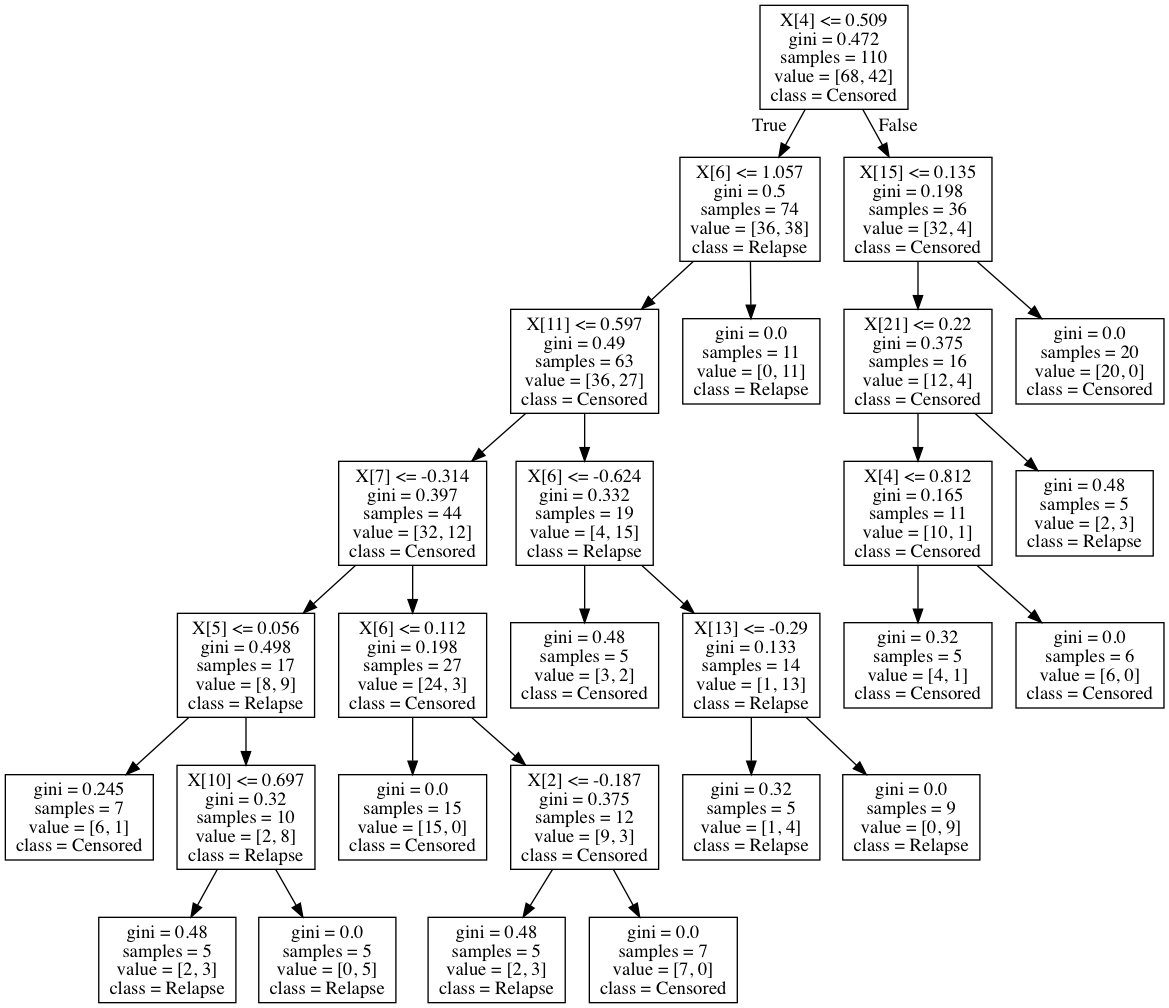

In [65]:
# PRINT BEST TREE
from IPython.display import Image  
import pydotplus
from sklearn import tree

bestTree = DecisionTreeClassifier(max_features = "sqrt", max_depth = None, min_samples_leaf = 5, min_samples_split = 2)
bestTree.fit(X_signature, y)

# Create DOT data
dot_data = tree.export_graphviz(bestTree, out_file=None, 
                                class_names=["Censored", "Relapse"])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())